In [2]:
"""
This script uses Numerator transaction data to calculate the monthly, bi-monthly, and tri-monthy churn rate for Modelo Customers.
It tracks the churn rate for all customers and for a filtered set of customers who have multiple purchases in the dataset.

The configuration file for the connection is specified using the pathlib package for cross-platform compatibility.
The script fetches the configuration from a YAML file located in the user's Documents/Github/ds-customer-lv/cfg directory.

Packages used:
- os: Standard library for operating system interactions.
- snowflake.connector: Snowflake's Python connector.
- pandas: For data manipulation and analysis.
- matplotlib.pyplot: For plotting.
- seaborn: For statistical data visualization.
- pathlib: For easy and portable file path manipulation.
"""

In [3]:
query = "SELECT * FROM DS_TEST_DB.DKEARNY.CJ_L_MAIN_STATIC_AGGREGATED"
df = sf.pull_sql_to_df(query)

In [4]:
df = df[df['MODELO_TOTAL'] > 0]
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])
df = df.sort_values(by=['USER_ID', 'TRANSACTION_DATE'])

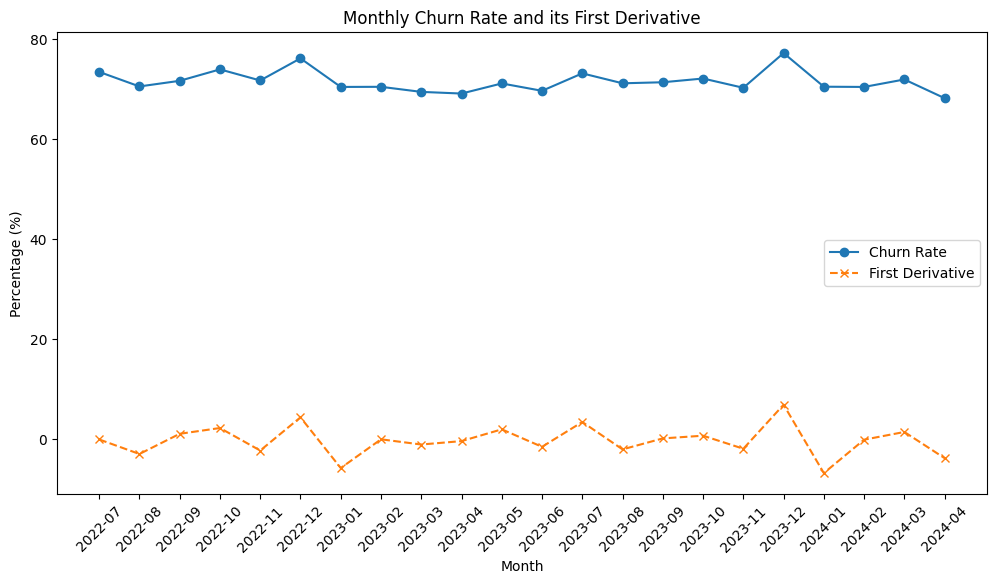

      Month  Churn Rate  First_Derivative
0   2022-07   73.450720          0.000000
1   2022-08   70.543046         -2.907674
2   2022-09   71.670082          1.127036
3   2022-10   73.952255          2.282173
4   2022-11   71.735242         -2.217013
5   2022-12   76.154873          4.419632
6   2023-01   70.444520         -5.710353
7   2023-02   70.471014          0.026495
8   2023-03   69.457197         -1.013818
9   2023-04   69.123723         -0.333474
10  2023-05   71.142697          2.018974
11  2023-06   69.670833         -1.471864
12  2023-07   73.157895          3.487062
13  2023-08   71.172203         -1.985692
14  2023-09   71.379962          0.207759
15  2023-10   72.128702          0.748740
16  2023-11   70.273323         -1.855380
17  2023-12   77.212020          6.938697
18  2024-01   70.491312         -6.720708
19  2024-02   70.444685         -0.046627
20  2024-03   71.938534          1.493849
21  2024-04   68.196319         -3.742215
Average Churn Rate: 71.56%


In [5]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-05-01')

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to April 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_month_start = current_start_month + pd.DateOffset(months=1)
    next_month_end = next_month_start + pd.DateOffset(months=1)
    
    # Identify users who made a purchase in the current month
    current_month_users = df[(df['TRANSACTION_DATE'] >= current_start_month) & (df['TRANSACTION_DATE'] < next_month_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following month
    next_month_users = df[(df['TRANSACTION_DATE'] >= next_month_start) & (df['TRANSACTION_DATE'] < next_month_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next month)
    churned_users = len(set(current_month_users) - set(next_month_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_month_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Monthly Churn Rate and its First Derivative')
plt.legend()
plt.show()

# Display the results
print(results_df)

average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate: {average_churn_rate:.2f}%")


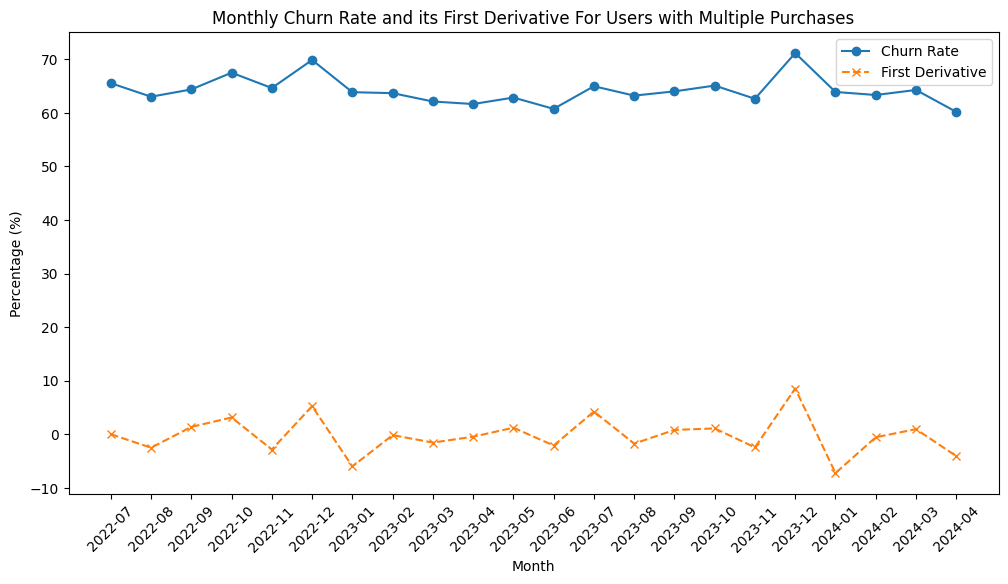

      Month  Churn Rate  First_Derivative
0   2022-07   65.559181          0.000000
1   2022-08   63.031915         -2.527266
2   2022-09   64.391500          1.359585
3   2022-10   67.515713          3.124213
4   2022-11   64.653244         -2.862469
5   2022-12   69.892111          5.238867
6   2023-01   63.873911         -6.018199
7   2023-02   63.697105         -0.176807
8   2023-03   62.135922         -1.561182
9   2023-04   61.663067         -0.472855
10  2023-05   62.872955          1.209888
11  2023-06   60.760647         -2.112308
12  2023-07   64.988558          4.227912
13  2023-08   63.233504         -1.755055
14  2023-09   64.029461          0.795957
15  2023-10   65.110696          1.081236
16  2023-11   62.645473         -2.465224
17  2023-12   71.179731          8.534258
18  2024-01   63.919414         -7.260317
19  2024-02   63.349025         -0.570389
20  2024-03   64.290012          0.940987
21  2024-04   60.196560         -4.093452
Average Churn Rate For Users with 

In [6]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Calculate the purchase counts
user_purchase_counts = df.groupby('USER_ID')['TRANSACTION_DATE'].nunique().reset_index()
user_purchase_counts.columns = ['USER_ID', 'PURCHASE_COUNT']

# Merge the purchase counts with the original data
df_with_purchase_counts = pd.merge(df, user_purchase_counts, on='USER_ID')

# Filter out users who made only one purchase
df_multiple_purchases = df_with_purchase_counts[df_with_purchase_counts['PURCHASE_COUNT'] > 1]

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-05-01')

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to April 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_month_start = current_start_month + pd.DateOffset(months=1)
    next_month_end = next_month_start + pd.DateOffset(months=1)
    
    # Identify users who made a purchase in the current month
    current_month_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= current_start_month) & (df_multiple_purchases['TRANSACTION_DATE'] < next_month_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following month
    next_month_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= next_month_start) & (df_multiple_purchases['TRANSACTION_DATE'] < next_month_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next month)
    churned_users = len(set(current_month_users) - set(next_month_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_month_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Monthly Churn Rate and its First Derivative For Users with Multiple Purchases')
plt.legend()
plt.show()

# Display the results
print(results_df)

# Calculate the average churn rate
average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate For Users with Multiple Purchases: {average_churn_rate:.2f}%")


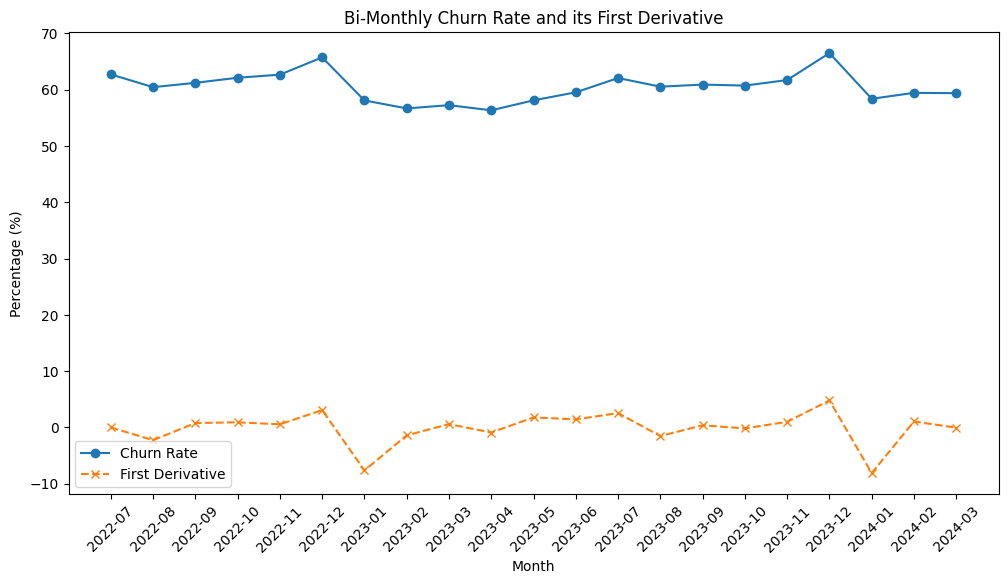

      Month  Churn Rate  First_Derivative
0   2022-07   62.725818          0.000000
1   2022-08   60.450331         -2.275486
2   2022-09   61.219262          0.768931
3   2022-10   62.122016          0.902754
4   2022-11   62.671437          0.549421
5   2022-12   65.740988          3.069551
6   2023-01   58.092976         -7.648012
7   2023-02   56.672705         -1.420271
8   2023-03   57.250878          0.578172
9   2023-04   56.338334         -0.912543
10  2023-05   58.107350          1.769015
11  2023-06   59.531773          1.424423
12  2023-07   62.073365          2.541593
13  2023-08   60.538373         -1.534992
14  2023-09   60.907372          0.368999
15  2023-10   60.728745         -0.178627
16  2023-11   61.712220          0.983476
17  2023-12   66.506678          4.794457
18  2024-01   58.388256         -8.118421
19  2024-02   59.436009          1.047752
20  2024-03   59.385343         -0.050666
Average Churn Rate: 60.50%


In [8]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-04-01') 

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to April 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_two_months_start = current_start_month + pd.DateOffset(months=1)
    next_two_months_end = current_start_month + pd.DateOffset(months=3)
    
    # Identify users who made a purchase in the current month
    current_month_users = df[(df['TRANSACTION_DATE'] >= current_start_month) & (df['TRANSACTION_DATE'] < next_two_months_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following two months
    next_two_months_users = df[(df['TRANSACTION_DATE'] >= next_two_months_start) & (df['TRANSACTION_DATE'] < next_two_months_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next two months)
    churned_users = len(set(current_month_users) - set(next_two_months_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_two_months_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Bi-Monthly Churn Rate and its First Derivative')
plt.legend()
plt.show()

# Display the results
print(results_df)

# Calculate the average churn rate
average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate: {average_churn_rate:.2f}%")


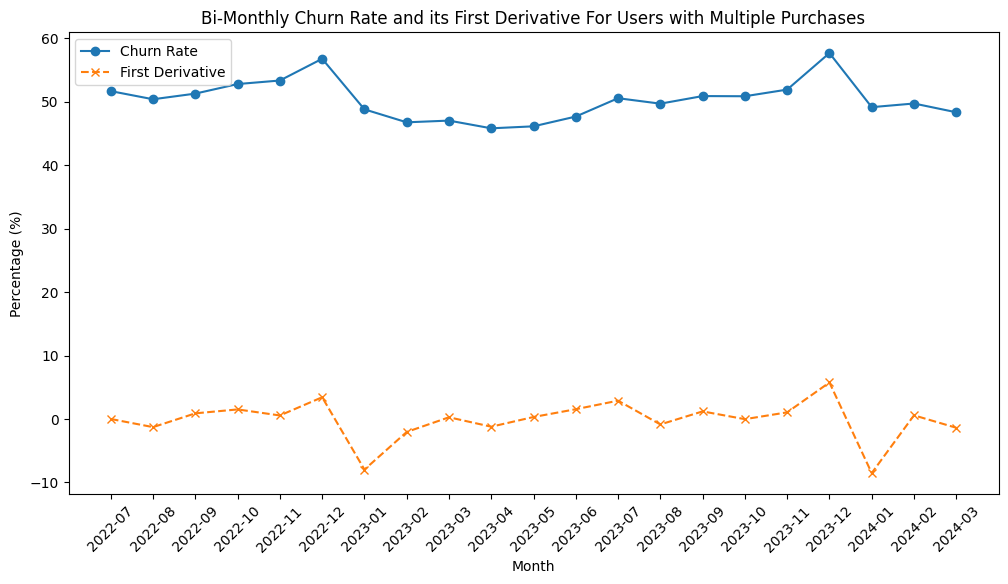

      Month  Churn Rate  First_Derivative
0   2022-07   51.646396          0.000000
1   2022-08   50.365691         -1.280704
2   2022-09   51.255634          0.889943
3   2022-10   52.762157          1.506523
4   2022-11   53.318419          0.556262
5   2022-12   56.743088          3.424669
6   2023-01   48.776441         -7.966647
7   2023-02   46.733482         -2.042959
8   2023-03   47.003683          0.270201
9   2023-04   45.788337         -1.215346
10  2023-05   46.102021          0.313684
11  2023-06   47.642906          1.540885
12  2023-07   50.530476          2.887570
13  2023-08   49.671293         -0.859183
14  2023-09   50.867189          1.195896
15  2023-10   50.840224         -0.026965
16  2023-11   51.887596          1.047372
17  2023-12   57.640538          5.752943
18  2024-01   49.120879         -8.519659
19  2024-02   49.697377          0.576498
20  2024-03   48.315283         -1.382094
Average Churn Rate For Users with Multiple Purchases: 50.32%


In [9]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Calculate the purchase counts
user_purchase_counts = df.groupby('USER_ID')['TRANSACTION_DATE'].nunique().reset_index()
user_purchase_counts.columns = ['USER_ID', 'PURCHASE_COUNT']

# Merge the purchase counts with the original data
df_with_purchase_counts = pd.merge(df, user_purchase_counts, on='USER_ID')

# Filter out users who made only one purchase
df_multiple_purchases = df_with_purchase_counts[df_with_purchase_counts['PURCHASE_COUNT'] > 1]

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-04-01') 

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to April 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_two_months_start = current_start_month + pd.DateOffset(months=1)
    next_two_months_end = current_start_month + pd.DateOffset(months=3)
    
    # Identify users who made a purchase in the current month
    current_month_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= current_start_month) & (df_multiple_purchases['TRANSACTION_DATE'] < next_two_months_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following two months
    next_two_months_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= next_two_months_start) & (df_multiple_purchases['TRANSACTION_DATE'] < next_two_months_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next two months)
    churned_users = len(set(current_month_users) - set(next_two_months_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_two_months_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Bi-Monthly Churn Rate and its First Derivative For Users with Multiple Purchases')
plt.legend()
plt.show()

# Display the results
print(results_df)

# Calculate the average churn rate
average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate For Users with Multiple Purchases: {average_churn_rate:.2f}%")


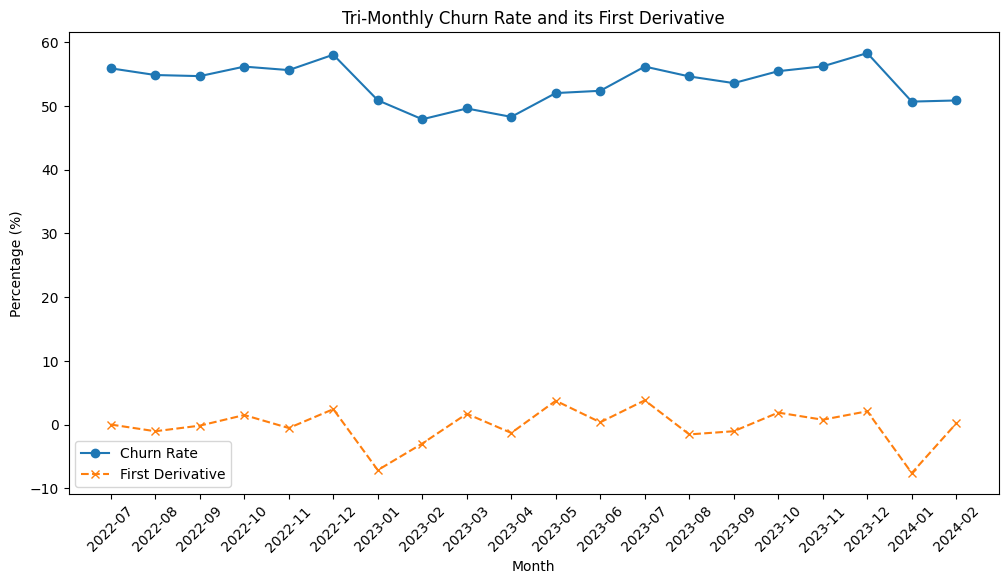

      Month  Churn Rate  First_Derivative
0   2022-07   55.911274          0.000000
1   2022-08   54.860927         -1.050347
2   2022-09   54.687500         -0.173427
3   2022-10   56.180371          1.492871
4   2022-11   55.635063         -0.545309
5   2022-12   58.050734          2.415672
6   2023-01   50.899220         -7.151515
7   2023-02   47.916667         -2.982553
8   2023-03   49.608426          1.691759
9   2023-04   48.293107         -1.315318
10  2023-05   52.029175          3.736068
11  2023-06   52.385143          0.355968
12  2023-07   56.188198          3.803054
13  2023-08   54.639175         -1.549023
14  2023-09   53.591682         -1.047493
15  2023-10   55.465587          1.873905
16  2023-11   56.223176          0.757589
17  2023-12   58.305509          2.082333
18  2024-01   50.689035         -7.616474
19  2024-02   50.867679          0.178644
Average Churn Rate: 53.62%


In [10]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-03-01')  # End date should be 3 months before the last date to account for the 3-month window

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to March 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_three_months_start = current_start_month + pd.DateOffset(months=1)
    next_three_months_end = current_start_month + pd.DateOffset(months=4)
    
    # Identify users who made a purchase in the current month
    current_month_users = df[(df['TRANSACTION_DATE'] >= current_start_month) & (df['TRANSACTION_DATE'] < next_three_months_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following three months
    next_three_months_users = df[(df['TRANSACTION_DATE'] >= next_three_months_start) & (df['TRANSACTION_DATE'] < next_three_months_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next three months)
    churned_users = len(set(current_month_users) - set(next_three_months_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_three_months_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Tri-Monthly Churn Rate and its First Derivative')
plt.legend()
plt.show()

# Display the results
print(results_df)

# Calculate the average churn rate
average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate: {average_churn_rate:.2f}%")

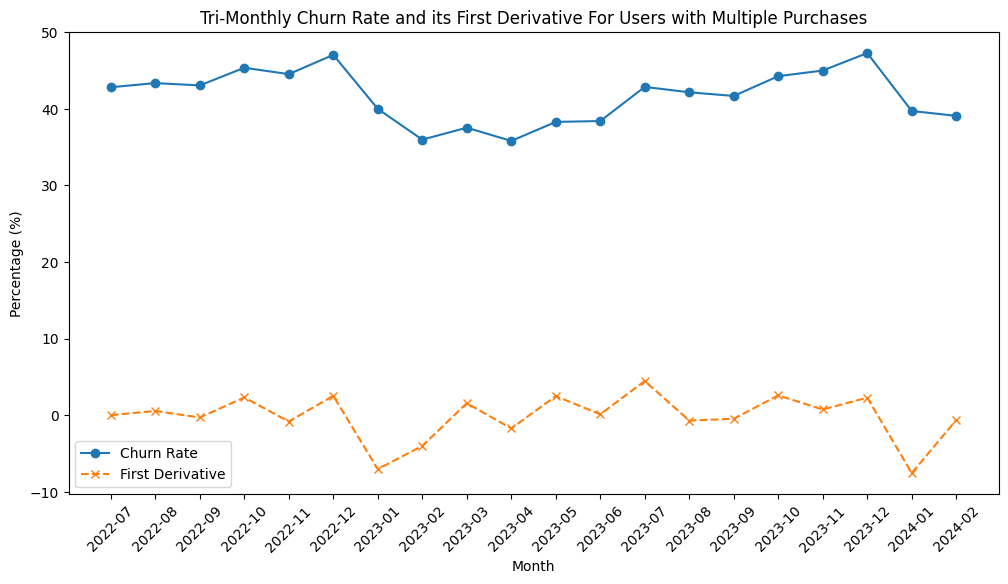

      Month  Churn Rate  First_Derivative
0   2022-07   42.806289          0.000000
1   2022-08   43.351064          0.544775
2   2022-09   43.045718         -0.305346
3   2022-10   45.352299          2.306581
4   2022-11   44.519016         -0.833283
5   2022-12   47.033041          2.514025
6   2023-01   39.983409         -7.049632
7   2023-02   35.968820         -4.014590
8   2023-03   37.529294          1.560474
9   2023-04   35.799136         -1.730158
10  2023-05   38.282002          2.482866
11  2023-06   38.396721          0.114719
12  2023-07   42.854171          4.457450
13  2023-08   42.147553         -0.706618
14  2023-09   41.672606         -0.474947
15  2023-10   44.251800          2.579194
16  2023-11   44.990065          0.738265
17  2023-12   47.268409          2.278343
18  2024-01   39.706960         -7.561449
19  2024-02   39.071957         -0.635003
Average Churn Rate For Users with Multiple Purchases: 41.70%


In [11]:
# Ensure the transaction date is in datetime format
df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'])

# Calculate the purchase counts
user_purchase_counts = df.groupby('USER_ID')['TRANSACTION_DATE'].nunique().reset_index()
user_purchase_counts.columns = ['USER_ID', 'PURCHASE_COUNT']

# Merge the purchase counts with the original data
df_with_purchase_counts = pd.merge(df, user_purchase_counts, on='USER_ID')

# Filter out users who made only one purchase
df_multiple_purchases = df_with_purchase_counts[df_with_purchase_counts['PURCHASE_COUNT'] > 1]

# Define the start and end dates for tracking
start_tracking_date = pd.to_datetime('2022-07-01')
end_tracking_date = pd.to_datetime('2024-03-01')  # End date should be 3 months before the last date to account for the 3-month window

# Initialize an empty list to store all results
results = []

# Iterate over each month from July 2022 to March 2024
current_start_month = start_tracking_date
while current_start_month < end_tracking_date:
    next_three_months_start = current_start_month + pd.DateOffset(months=1)
    next_three_months_end = current_start_month + pd.DateOffset(months=4)
    
    # Identify users who made a purchase in the current month
    current_month_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= current_start_month) & (df_multiple_purchases['TRANSACTION_DATE'] < next_three_months_start)]['USER_ID'].unique()
    
    # Identify users who made a purchase in the following three months
    next_three_months_users = df_multiple_purchases[(df_multiple_purchases['TRANSACTION_DATE'] >= next_three_months_start) & (df_multiple_purchases['TRANSACTION_DATE'] < next_three_months_end)]['USER_ID'].unique()
    
    # Calculate the churn rate (users who did not repurchase in the next three months)
    churned_users = len(set(current_month_users) - set(next_three_months_users))
    churn_rate = churned_users / len(current_month_users) * 100 if len(current_month_users) > 0 else 0
    
    # Append the result to the results list
    results.append({
        'Month': current_start_month.strftime('%Y-%m'),
        'Churn Rate': churn_rate
    })
    
    # Move to the next month
    current_start_month = next_three_months_start

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the first derivative (rate of change)
results_df['First_Derivative'] = results_df['Churn Rate'].diff().fillna(0)

# Plot the churn rate and its first derivative
plt.figure(figsize=(12, 6))
plt.plot(results_df['Month'], results_df['Churn Rate'], label='Churn Rate', marker='o')
plt.plot(results_df['Month'], results_df['First_Derivative'], label='First Derivative', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.title('Tri-Monthly Churn Rate and its First Derivative For Users with Multiple Purchases')
plt.legend()
plt.show()

# Display the results
print(results_df)

# Calculate the average churn rate
average_churn_rate = results_df['Churn Rate'].mean()
print(f"Average Churn Rate For Users with Multiple Purchases: {average_churn_rate:.2f}%")